|      Nguyen, Duc Trung
|      Thomson, Alasdair

# 1. Background to the problem

In this assignment, we will try to develop a trading bot focus on short-term investment of blue chip stocks. For this, we wil perform 2 tasks:

(1) Applying **Neural Network**, specifically the Long Short-Term Memory (LSTM) Neural network, using previous days closing price and other technical indicators as input, to make next day price prediction

(2) Applying **Genetic Algorithm** to develop an efficient trading strategy that can utlize the price prediction, maximize profit while also maintain certain level of flexibility.

For task 1, we will be using various technical indicators including:

1. **Simple Moving Average (SMA)**: SMA calculates the average price of a security over a specific period, helping to smooth out price fluctuations and identify trends.

2. **Exponential Moving Average (EMA)**: EMA is a type of moving average that gives more weight to recent prices, making it more responsive to recent price changes and useful for trend identification.

3. **Relative Strength Index (RSI)**: RSI is a momentum oscillator ranging from 0 to 100, used to identify overbought or oversold conditions in a security based on recent price movements.

4. **Moving Average Convergence Divergence (MACD)**: MACD is a trend-following momentum indicator that compares two moving averages of a security's price to identify bullish and bearish signals and potential trend reversals.

We will be using data of a short time period (previous 1 to 5 days), but by incorporating these technical indicators, our predictions would based on infomation of a much bigger time window while still maintain relatively fast.

We will be building on other research utilizing LSTM and using many of the techniques identified in this paper (https://www.analyticsvidhya.com/blog/2021/12/stock-price-prediction-using-lstm/).

## 1.1 A note on the use of python

Please note that this assignment is delivered in Python with the permission of the professor. This is due to our use of a neural network in creating predictions which we found was easier to perform in Python.

In [ ]:
#@title
import sys
print('python version: ',sys.version)

python version:  3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


# 2. Overview of chosen data

For our analysis, we will be working with the top 20 stocks by capitalization from the S&P 500. The main reason for this choice is because:

(1) S&P 500 stocks are the most liquid stocks in the markets, which would allow use to act on our prediction with minimal delay

(2) S&P 500 companies are subject to high regulatory compliance with high level of capitalization, which make these stocks less subceptible for malpractices and market manimpulation comparing to others

We will be using the data from 9/2015 to 12/2019, in which the 4 months period in 2015 will be use as buffer for calculating the technical indicators, data of the period 2016 to 2018 are use for training and 2019 will be use for testing purpose.  

## 2.1. Importing the library

In [ ]:
pip install yfinance

In [ ]:
pip install deap

SyntaxError: invalid syntax (<ipython-input-2-39e281564bab>, line 1)

In [ ]:
#@title
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib
import sklearn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
import math
from sklearn.metrics import mean_squared_error
print("yfinance version:", yf.__version__)
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("TensorFlow version:", tf.__version__)

yfinance version: 0.2.37
Pandas version: 2.0.3
NumPy version: 1.25.2
Matplotlib version: 3.7.1
Scikit-learn version: 1.2.2
TensorFlow version: 2.15.0


##2.2. Importing stock data

In [ ]:
#@title
#TOP 20 STOCKS BY MARKET CAP
top_20_sp500_tickers=[
    'AAPL', 'MSFT', 'AMZN', 'ABBV',
    'GOOGL', 'KO', 'CAT',
    'JNJ', 'JPM', 'V', 'PG', 'UNH', 'INTC', 'HD', 'MA', 'VZ', 'T', 'DIS', 'MRK', 'PFE']
#Crawling the S&P500 index for comparison
sp500_ticker="^GSPC"

#Create an empty dictionary to store data
SP_stock_data={}
start="2015-09-01"  #data start from 9-2015 as buffer for moving average and other momentum index
end="2020-01-01"

#Download S&P 500 index data
try:
    SP500_data=yf.download(sp500_ticker, start=start, end=end)
except Exception as e:
    print(f"Failed to download data for {sp500_ticker}: {e}")

#Loop through each ticker symbol and download its stock data for 2017
all_data_downloaded=True  #Flag to check if all data has been downloaded
for ticker in top_20_sp500_tickers:
    try:
        SP_stock_data[ticker]=yf.download(ticker, start=start, end=end)
    except Exception as e:
        print(f"Failed to download data for {ticker}: {e}")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
#@title
#URL of the Wikipedia page containing the table
url='https://en.wikipedia.org/wiki/S%26P_100'

#Read the HTML tables from the URL
tables=pd.read_html(url)

#Check if tables were found
if tables:
    #Assume you want the first table found on the page
    stock_table=tables[2]  #Index 0 corresponds to the first table
else:
    print("No tables found on the page.")

#Create a list of stock symbols from the dataframe
subset_table=stock_table[stock_table['Symbol'].isin(top_20_sp500_tickers)]

#Print the subset table
print(subset_table)

   Symbol                Name                  Sector
0    AAPL               Apple  Information Technology
1    ABBV              AbbVie             Health Care
9    AMZN              Amazon  Consumer Discretionary
20    CAT         Caterpillar             Industrials
33    DIS              Disney  Communication Services
44  GOOGL  Alphabet (Class A)  Communication Services
46     HD          Home Depot  Consumer Discretionary
49   INTC               Intel  Information Technology
51    JNJ   Johnson & Johnson             Health Care
52    JPM      JPMorgan Chase              Financials
54     KO           Coca-Cola        Consumer Staples
59     MA          Mastercard  Information Technology
67    MRK               Merck             Health Care
69   MSFT           Microsoft  Information Technology
76    PFE              Pfizer             Health Care
77     PG    Procter & Gamble        Consumer Staples
86      T                AT&T  Communication Services
92    UNH  UnitedHealth Grou

As our trading bot will only consider buy and sell, and not including complex activities like short-selling, so we choose stocks from various industries to maximize investment opportunities even under market down trend.

In [ ]:
df=SP_stock_data.copy()

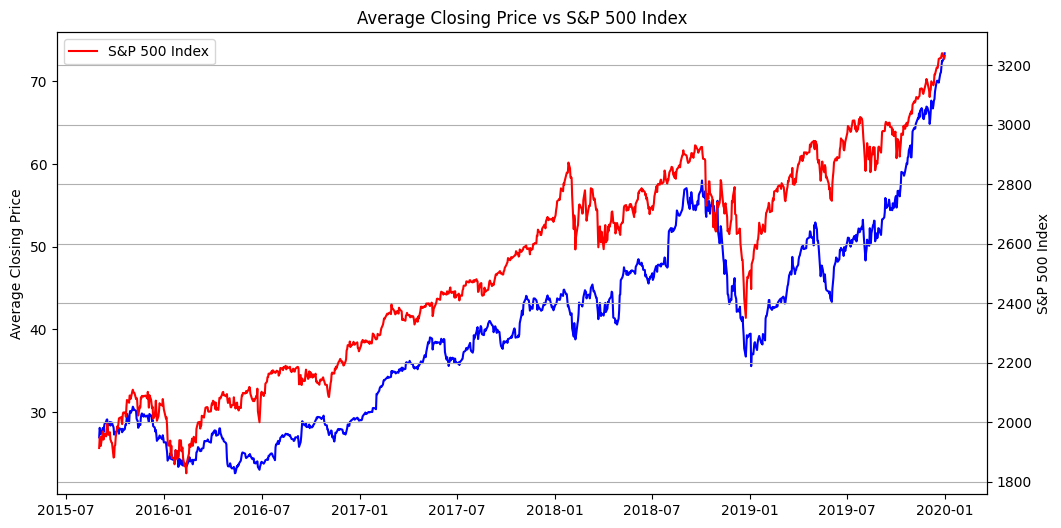

In [ ]:
#@title
#Calculate average closing price for each day across all stocks
average_prices=pd.DataFrame()

for ticker, stock_df in SP_stock_data.items():
      if average_prices.empty:
          average_prices=stock_df['Close'].rename(ticker)
      else:
          average_prices=pd.concat([average_prices, stock_df['Close']], axis=1, keys=[ticker])

#Calculate average closing price across all stocks for each day
average_prices['Average']=average_prices.mean(axis=1)

#Plot both the average closing price and the S&P 500 index
plt.figure(figsize=(12, 6))

#Plot average closing price with left y-axis
plt.plot(average_prices.index, average_prices['Average'], label='Average Closing Price', color='blue')
plt.ylabel('Average Closing Price')

#Create secondary y-axis for S&P 500 index
ax2=plt.gca().twinx()
ax2.plot(SP500_data.index, SP500_data['Close'], label='S&P 500 Index', color='red')
ax2.set_ylabel('S&P 500 Index')

#Additional configurations
plt.title('Average Closing Price vs S&P 500 Index')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

The average closing price of our basket of 20 stocks are present in blue and use the y-axis on the left, while the S&P500 index are presented in red and use the y-axis on the right. We can see that the 2 figures are heavily correlated, since the 20 stocks make up a large portion in term of capitalization of the S&P500 and cover different sectors.
We will be using the period from 2016 to end of 2018 for training, and 2019 for testing. While there is a major market downtrend around 12/2018, the overal market movement of these 2 time period are both upward with similar seasonality.

In [ ]:
#@title
start_train='2015-12-31'
cutoff_date='2018-12-31'
end_test='2019-12-31'

#Calculate percentage change of ^GSPC from start of 2016 to end of 2018
sp500_pct_change_2016_2018=(SP500_data['Close'].loc[cutoff_date] - SP500_data['Close'].loc[start_train]) / SP500_data['Close'].loc[start_train] * 100

#Calculate percentage change of ^GSPC from start to end of 2019
sp500_pct_change_2019=SP500_data['Close'].pct_change().loc[cutoff_date:end_test].sum() * 100

#Calculate percentage change of average prices from start of 2016 to end of 2018
average_prices_pct_change_2016_2018=(average_prices['Average'].loc[cutoff_date] - average_prices['Average'].loc[start_train]) / average_prices['Average'].loc[start_train] * 100

#Calculate percentage change of average prices from start to end of 2019
average_prices_pct_change_2019=average_prices['Average'].pct_change().loc[cutoff_date:end_test].sum() * 100

print(f"Percentage change of S&P500 from start of 2016 to end of 2018: {sp500_pct_change_2016_2018:.2f}%")
print(f"Percentage change of S&P500 from start to end of 2019: {sp500_pct_change_2019:.2f}%")
print(f"Percentage change of average prices from start of 2016 to end of 2018: {average_prices_pct_change_2016_2018:.2f}%")
print(f"Percentage change of average prices from start to end of 2019: {average_prices_pct_change_2019:.2f}%")


Percentage change of S&P500 from start of 2016 to end of 2018: 22.65%
Percentage change of S&P500 from start to end of 2019: 27.01%
Percentage change of average prices from start of 2016 to end of 2018: 49.86%
Percentage change of average prices from start to end of 2019: 66.63%


Based on the above figure, we can see that the training period profit was heavily affect by the 12/2018 downtrend, and the basket of 20 stocks we picked has a relatively better performance compare to the S&P.

In [ ]:
#@title
#We take the index of 2018-12-31 as the cutoff for the training and testing process
cutoff_index=SP_stock_data['AAPL'].index.get_loc('2018-12-31')

##2.3. Perform feature engineer
We calculate various financial technical indicators and compare the result to see if using additional data help with the prediction process. Since we will be using LSTM, a form of recurrent neural network, and as neural network typically can perform feature engineering by itself, so this step can typically be skip. The reason we are doing this is to incorporate information of stock's momentum in a longer period (between 14 to 50 days) than the time window we will be using (1 and 5 days) into the model.

In [ ]:
#@title
#Function to calculate technical indicators for a given DataFrame
def add_technical_indicators(data):
    #Calculate SMAs
    data['SMA_10']=data['Close'].rolling(window=10).mean()
    data['SMA_20']=data['Close'].rolling(window=20).mean()
    data['SMA_50']=data['Close'].rolling(window=50).mean()

    #Calculate EMAs
    data['EMA_12']=data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA_26']=data['Close'].ewm(span=26, adjust=False).mean()

    #Calculate RSI
    delta=data['Close'].diff(1)
    gain=(delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss=(-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs=gain / loss
    data['RSI']=100 - (100 / (1 + rs))

    #Calculate MACD and Signal Line
    data['MACD']=data['EMA_12'] - data['EMA_26']
    data['Signal_Line']=data['MACD'].ewm(span=9, adjust=False).mean()

    return data

#Iterate over each ticker in the dictionary and adding technical indicators
for ticker in df:
    df[ticker]=add_technical_indicators(df[ticker])

In [ ]:
#@title
aapl_df=df['AAPL'].drop(columns=['Open', 'High', 'Low', 'Adj Close'])
aapl_df=aapl_df.dropna()

## 2.4. Predict stock price using LSTM

### 2.4.1. Predict using time_step=1

In [ ]:
#@title
#Extract features and target
features_close=aapl_df['Close']
features_all=aapl_df.copy()
features_tech=aapl_df.drop(columns=['Close'])
target=aapl_df['Close']

#Scalethe features
scaler_features_close=StandardScaler()
features_close_scaled=scaler_features_close.fit_transform(features_close.values.reshape(-1,1))

scaler_features_all=StandardScaler()
features_all_scaled=scaler_features_all.fit_transform(features_all)

scaler_features_tech=StandardScaler()
features_tech_scaled=scaler_features_tech.fit_transform(features_tech)

#Scale the target
scaler_target=StandardScaler()
target_scaled=scaler_target.fit_transform(target.values.reshape(-1, 1))

#Function to create sequences for LSTM model
def create_sequences(features, target, time_steps=1):
    X, y=[], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

7/7 [==============================] - 0s 4ms/step
Test Mean Squared Error for Close feature: 34.47169705504316
Test Mean Squared Error for All features: 1.212663186801293
Test Mean Squared Error for Technical features: 2.904653643020139


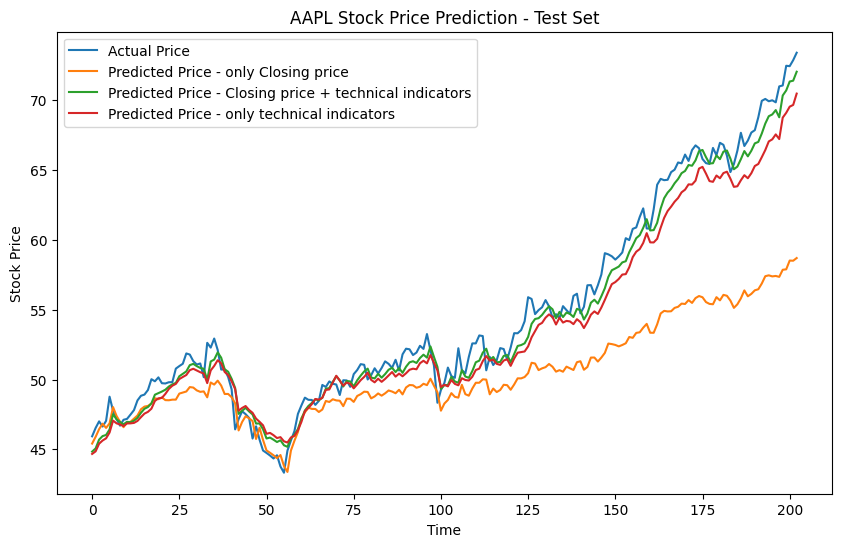

In [ ]:
#@title
time_steps=1
X_close, y_close=create_sequences(features_close_scaled, target_scaled, time_steps)
X_all, y_all=create_sequences(features_all_scaled, target_scaled, time_steps)
X_tech, y_tech=create_sequences(features_tech_scaled, target_scaled, time_steps)


#Split the datainto training and test sets
split_size= cutoff_index #int(X_close.shape[0] * 0.8)
X_train_close, X_test_close=X_close[:split_size], X_close[split_size:]
X_train_all, X_test_all=X_all[:split_size], X_all[split_size:]
X_train_tech, X_test_tech=X_tech[:split_size], X_tech[split_size:]

y_train, y_test=y_close[:split_size], y_close[split_size:]

np.random.seed(42)
tf.random.set_seed(42)

#Define LSTM model for Close feature
model_close=Sequential([
    LSTM(350, input_shape=(X_train_close.shape[1], X_train_close.shape[2])),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    Dense(1)
])

#Define LSTM model for All features
model_all=Sequential([
    LSTM(350, input_shape=(X_train_all.shape[1], X_train_all.shape[2])),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    Dense(1)
])

#Define LSTM model for just technical indicators
model_tech=Sequential([
    LSTM(350, input_shape=(X_train_tech.shape[1], X_train_tech.shape[2])),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    Dense(1)
])

#Compile the models
optimizer_close=Adam(learning_rate=0.001, clipvalue=1.0)
model_close.compile(optimizer=optimizer_close, loss='mean_squared_error')
optimizer_all=Adam(learning_rate=0.001, clipvalue=1.0)
model_all.compile(optimizer=optimizer_all, loss='mean_squared_error')
optimizer_tech=Adam(learning_rate=0.001, clipvalue=1.0)
model_tech.compile(optimizer=optimizer_tech, loss='mean_squared_error')

#Train the models
history_close=model_close.fit(X_train_close, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=64)
history_all=model_all.fit(X_train_all, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=64)
history_tech=model_tech.fit(X_train_tech, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=64)

#Predictions on test set for Close feature
predictions_test_scaled_close=model_close.predict(X_test_close)
predictions_test_close=scaler_target.inverse_transform(predictions_test_scaled_close)

#Predictions on test set for All features
predictions_test_scaled_all=model_all.predict(X_test_all)
predictions_test_all=scaler_target.inverse_transform(predictions_test_scaled_all)

#Predictions on test set for just technical features
predictions_test_scaled_tech=model_tech.predict(X_test_tech)
predictions_test_tech=scaler_target.inverse_transform(predictions_test_scaled_tech)

#Evaluate the models with Mean Squared Error on test data
mse_test_close=mean_squared_error(scaler_target.inverse_transform(y_test), predictions_test_close)
mse_test_all=mean_squared_error(scaler_target.inverse_transform(y_test), predictions_test_all)
mse_test_tech=mean_squared_error(scaler_target.inverse_transform(y_test), predictions_test_tech)

print(f'Test Mean Squared Error for Close feature: {mse_test_close}')
print(f'Test Mean Squared Error for All features: {mse_test_all}')
print(f'Test Mean Squared Error for Technical features: {mse_test_tech}')

#Plotting actual vs. predicted prices on test data
plt.figure(figsize=(10, 6))
plt.plot(scaler_target.inverse_transform(y_test), label='Actual Price')
plt.plot(predictions_test_close, label='Predicted Price - only Closing price')
plt.plot(predictions_test_all, label='Predicted Price - Closing price + technical indicators')
plt.plot(predictions_test_tech, label='Predicted Price - only technical indicators')
plt.title('AAPL Stock Price Prediction - Test Set')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


### 2.4.2. Predict using time_step=5

In [ ]:
#@title
#Define time steps and create sequences
time_steps=5
X_close, y_close=create_sequences(features_close_scaled, target_scaled, time_steps)
X_all, y_all=create_sequences(features_all_scaled, target_scaled, time_steps)
X_tech, y_tech=create_sequences(features_tech_scaled, target_scaled, time_steps)

#Split the data into training and testsets
split_size=int(X_close.shape[0] * 0.8)
X_train_close, X_test_close=X_close[:split_size], X_close[split_size:]
X_train_all, X_test_all=X_all[:split_size], X_all[split_size:]
X_train_tech, X_test_tech=X_tech[:split_size], X_tech[split_size:]

y_train, y_test=y_close[:split_size], y_close[split_size:]

np.random.seed(42)
tf.random.set_seed(42)

#Define LSTM model for Close feature
model_close=Sequential([
    LSTM(350, input_shape=(X_train_close.shape[1], X_train_close.shape[2])),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    Dense(1)
])

#Define LSTM model for All features
model_all=Sequential([
    LSTM(350, input_shape=(X_train_all.shape[1], X_train_all.shape[2])),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    Dense(1)
])

#Define LSTM model for just technical indicators
model_tech=Sequential([
    LSTM(350, input_shape=(X_train_tech.shape[1], X_train_tech.shape[2])),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    Dense(1)
])

#Compile the models
optimizer_close=Adam(learning_rate=0.001, clipvalue=1.0)
model_close.compile(optimizer=optimizer_close, loss='mean_squared_error')
optimizer_all=Adam(learning_rate=0.001, clipvalue=1.0)
model_all.compile(optimizer=optimizer_all, loss='mean_squared_error')
optimizer_tech=Adam(learning_rate=0.001, clipvalue=1.0)
model_tech.compile(optimizer=optimizer_tech, loss='mean_squared_error')

#Train the models
history_close=model_close.fit(X_train_close, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=64)
history_all=model_all.fit(X_train_all, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=64)
history_tech=model_tech.fit(X_train_tech, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=64)

#Predictions on test set for Close feature
predictions_test_scaled_close=model_close.predict(X_test_close)
predictions_test_close=scaler_target.inverse_transform(predictions_test_scaled_close)

#Predictions on test set for All features
predictions_test_scaled_all=model_all.predict(X_test_all)
predictions_test_all=scaler_target.inverse_transform(predictions_test_scaled_all)

#Predictions on test set for just technical features
predictions_test_scaled_tech=model_tech.predict(X_test_tech)
predictions_test_tech=scaler_target.inverse_transform(predictions_test_scaled_tech)

7/7 [==============================] - 0s 8ms/step


Test Mean Squared Error for Close feature: 3.6492508098265786
Test Mean Squared Error for All features: 1.468306868091811
Test Mean Squared Error for Technical features: 1.802232411033961


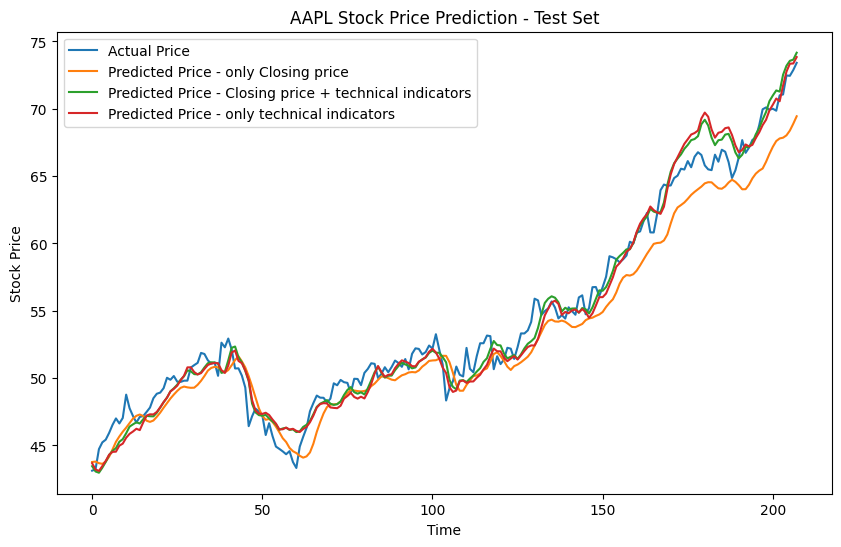

In [ ]:
#@title
#Evaluate the models with Mean Squared Error on test data
mse_test_close=mean_squared_error(scaler_target.inverse_transform(y_test), predictions_test_close)
mse_test_all=mean_squared_error(scaler_target.inverse_transform(y_test), predictions_test_all)
mse_test_tech=mean_squared_error(scaler_target.inverse_transform(y_test), predictions_test_tech)

print(f'Test Mean Squared Error for Close feature: {mse_test_close}')
print(f'Test Mean Squared Error for All features: {mse_test_all}')
print(f'Test Mean Squared Error for Technical features: {mse_test_tech}')

#Plotting actual vs. predicted prices on test data
plt.figure(figsize=(10, 6))
plt.plot(scaler_target.inverse_transform(y_test), label='Actual Price')
plt.plot(predictions_test_close, label='Predicted Price - only Closing price')
plt.plot(predictions_test_all, label='Predicted Price - Closing price + technical indicators')
plt.plot(predictions_test_tech, label='Predicted Price - only technical indicators')
plt.title('AAPL Stock Price Prediction - Test Set')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

We performed prediction 2 time window of 1 and 5 trading days (equivalent to 1 week) with 3 combination of data which are:
- Close: just using previous day(s) closing price of the stock
- All: using previous day(s) closing price along with 10 technical indicators
- Technical: just using the 10 technical indcators

Overall, We observe that adding the technical indicators into the model does improve the prediction. And while using a time window of 5 days slightly reduce the All prediction, as this seem to improve the Close and Technical prediction, we will be training the prediction model using 5 days of All data to predict the next day Closing price.

## 2.5. Applying the model to all of the stocks

In [ ]:
#@title
#Dictionary to hold cleaned data
cleaned_data={}

for ticker, data in SP_stock_data.items():
    cleaned_data[ticker]=data.dropna()

#Track the shapes and their counts
shape_counts={}

for data in cleaned_data.values():
    shape=data.shape
    if shape in shape_counts:
        shape_counts[shape] += 1
    else:
        shape_counts[shape]=1

#Determine the most common shape
most_common_shape=max(shape_counts, key=shape_counts.get)

#Filter datasets by the most common shape
filtered_data={ticker: data for ticker, data in cleaned_data.items() if data.shape == most_common_shape}

#Print the tickers and shapes of the remaining datasets
#for ticker, data in filtered_data.items():
#   print(f"{ticker} data shape: {data.shape}")

In [ ]:
#@title
modified_data={}
for ticker, df in filtered_data.items():
    modified_df=df.drop(columns=[ 'Adj Close', ])
    modified_data[ticker]=modified_df

We will loop through the 20 stocks, train 20 models (1 for each stocks), then using the resulting models to perform 2 predictions: (1) for the training period and (2) for the testing period


In [ ]:
#@title
#Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

train_data={}

for ticker, df in filtered_data.items():
    #Filter the DataFrame for entries from 2016 to 2019
    df_filtered=df[(df.index >= "2016-01-01") & (df.index < "2020-01-01")]
    df_filtered=df_filtered.drop(columns=['Adj Close'], errors='ignore')

    #Store the filtered data in the new dictionary
    train_data[ticker]=df_filtered

#Modified predictions storage to include dates, predictions, and actual prices
predictions_and_actuals_test={}
mse_values=[]

#Initialize dictionaries for storing training predictions and MSE values
predictions_and_actuals={}
train_mse_values=[]

#Function to create sequences for LSTM model, modified to return the remaining dates
def create_sequences(features, target, dates, time_steps=1):
    X, y, dates_seq=[], [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
        dates_seq.append(dates[i + time_steps])  #Capture the corresponding date
    return np.array(X), np.array(y), np.array(dates_seq)

#Loop through each ticker's data
for ticker, df in train_data.items():
    print(f"Processing {ticker}...")
    df=df.dropna()

    features=df.copy()
    target=df['Close']
    dates=df.index

    scaler_features=StandardScaler()
    features_scaled=scaler_features.fit_transform(features)

    scaler_target=StandardScaler()
    target_scaled=scaler_target.fit_transform(target.values.reshape(-1, 1))

    #Define time steps and create sequences
    time_steps=5
    X, y, dates_seq=create_sequences(features_scaled, target_scaled, dates, time_steps)

    #Split the data into training and test sets
    split_size=int(X.shape[0] * 0.75)
    X_train, X_test=X[:split_size], X[split_size:]
    y_train, y_test=y[:split_size], y[split_size:]
    dates_train, dates_test=dates_seq[:split_size], dates_seq[split_size:]

    #Define and compile the LSTM model
    model=Sequential([
        LSTM(400, input_shape=(X_train.shape[1], X_train.shape[2])),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),
        Dense(1)
    ])
    optimizer=Adam(learning_rate=0.001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    #Train the model
    model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=64)

    #Making predictions for the training period (2016-2018)
    predictions_scaled=model.predict(X_train)
    predictions=scaler_target.inverse_transform(predictions_scaled)
    actuals=scaler_target.inverse_transform(y_train.reshape(-1, 1))

    #Calculating MSE forthe predictions
    mse=mean_squared_error(actuals, predictions)
    train_mse_values.append((ticker, mse))
    print(f"{ticker} - Training Period MSE: {mse}")

    #Storing predictions and actuals for 2016-2018
    predictions_and_actuals[ticker]=pd.DataFrame({
        'Date': dates_train,
        'Predictions': predictions.flatten(),
        'Actuals': scaler_target.inverse_transform(y_train).flatten()
    })


    #Predictions on test set
    predictions_test_scaled=model.predict(X_test)
    predictions_test=scaler_target.inverse_transform(predictions_test_scaled)

    #Getting the actual prices for the test set (inverse transform)
    actual_prices=scaler_target.inverse_transform(y_test)

    #Storing combined data in the dictionary
    predictions_and_actuals_test[ticker]=pd.DataFrame({
        'Date': dates_test,
        'Predictions': predictions_test.flatten(),
        'Actuals': actual_prices.flatten()
    })

    #Optional: Evaluate the model with MSE and plot predictions for each stock
    mse_test=mean_squared_error(actual_prices, predictions_test)
    print(f'{ticker} Test MSE: {mse_test}')

    #Inside your loop, after calculating the MSE for a ticker:
    mse_test=mean_squared_error(actual_prices, predictions_test)
    mse_values.append((ticker, mse_test))

    #Define the file path where you want to save the model
#   model_path=f"{ticker}_model.h5"

    #Save the trained model to the specified file path
#  model.save(model_path)

Processing AAPL...
24/24 [==============================] - 1s 8ms/step
AAPL - Training Period MSE: 1.1511836915712435
8/8 [==============================] - 0s 9ms/step
AAPL Test MSE: 2.9938854703511435
Processing MSFT...
24/24 [==============================] - 1s 9ms/step
MSFT - Training Period MSE: 1.7759610579434473
8/8 [==============================] - 0s 7ms/step
MSFT Test MSE: 18.24175733938072
Processing AMZN...
24/24 [==============================] - 1s 7ms/step
AMZN - Training Period MSE: 3.226963040242966
8/8 [==============================] - 0s 6ms/step
AMZN Test MSE: 4.203007183394365
Processing ABBV...
24/24 [==============================] - 1s 7ms/step
ABBV - Training Period MSE: 3.933995855152044
8/8 [==============================] - 0s 7ms/step
ABBV Test MSE: 3.8564977898992123
Processing GOOGL...
24/24 [==============================] - 1s 8ms/step
GOOGL - Training Period MSE: 0.7622460583656211
8/8 [==============================] - 0s 8ms/step
GOOGL Test MSE: 

##2.6. Evaluate the prediction

In [ ]:
#@title
train_mse_df=pd.DataFrame(train_mse_values, columns=['Stocks','MSE'])
sorted_mse=train_mse_df.sort_values(by='MSE')
print(sorted_mse)

total_mse=0
for _, mse in train_mse_values:
    total_mse += mse  #Summing up all the MSE values
average_mse=total_mse / len(train_mse_values)  #Calculating the average
print(f"Average MSE across all tickers: {average_mse}")
#Extract MSE values from the list of tuples
mse_list=[mse for _, mse in train_mse_values]
#Sort the list of MSE values
mse_list.sort()
#Calculate the median
if len(mse_list) % 2 == 1:  #Odd number of elements
    median_mse=mse_list[len(mse_list) // 2]
else:  #Even number of elements, average the two middle values
    mid_index=len(mse_list) // 2
    median_mse=(mse_list[mid_index - 1] + mse_list[mid_index]) / 2
print(f"Median MSE across all tickers: {median_mse}")

   Stocks        MSE
16      T   0.202206
15     VZ   0.449939
5      KO   0.671687
4   GOOGL   0.743993
10     PG   0.961874
0    AAPL   1.071749
19    PFE   1.490650
1    MSFT   1.786262
18    MRK   1.825797
12   INTC   2.006049
17    DIS   2.010660
8     JPM   2.151407
7     JNJ   2.524676
9       V   3.082261
2    AMZN   3.247305
3    ABBV   4.018234
6     CAT   8.958984
13     HD   9.572498
11    UNH  12.104260
14     MA  14.108120
Average MSE across all tickers: 3.64943058512639
Median MSE across all tickers: 2.008354703836376


In [ ]:
#@title
mse_df=pd.DataFrame(mse_values, columns=['Stocks','MSE'])
sorted_mse=mse_df.sort_values(by='MSE')
print(sorted_mse)

total_mse=0
for _, mse in mse_values:
    total_mse += mse  #Summing up all the MSE values
average_mse=total_mse / len(mse_values)  #Calculating the average
print(f"Average MSE across all tickers: {average_mse}")
#Extract MSE values from the list of tuples
mse_list=[mse for _, mse in mse_values]
#Sort the list of MSE values
mse_list.sort()
#Calculate the median
if len(mse_list) % 2 == 1:  #Odd number of elements
    median_mse=mse_list[len(mse_list) // 2]
else:  #Even number of elements, average the two middle values
    mid_index=len(mse_list) // 2
    median_mse=(mse_list[mid_index - 1] + mse_list[mid_index]) / 2
print(f"Median MSE across all tickers: {median_mse}")

   Stocks        MSE
16      T   0.347508
15     VZ   1.261946
0    AAPL   2.535253
7     JNJ   3.480332
19    PFE   3.531944
4   GOOGL   3.607010
3    ABBV   3.957313
8     JPM   4.583970
12   INTC   6.011559
2    AMZN   8.660538
5      KO  11.043133
6     CAT  17.360109
10     PG  20.009045
9       V  20.903300
1    MSFT  24.482488
18    MRK  43.265220
11    UNH  55.595540
17    DIS  63.319656
14     MA  79.358931
13     HD  95.828879
Average MSE across all tickers: 23.45718364760329
Median MSE across all tickers: 9.8518356511353


# 3. Developing trading strategy

### Agent Trading an individual stock

#### Set up data

In [ ]:
#@title Evaluation setup
def process_eval_data(filtered_data, predictions_and_actuals, columns_to_drop):
    eval_data={}
    for ticker, df in filtered_data.items():
        #Sorting and merging steps
        df_sorted=df.sort_index()
        pred_df=predictions_and_actuals[ticker]
        pred_df_sorted=pred_df.sort_values(by='Date')
        pred_df_sorted['Date']=pd.to_datetime(pred_df_sorted['Date'])
        merged_df=pd.merge(df_sorted, pred_df_sorted, left_index=True, right_on='Date', how='right')

        #Calculation steps for predictions, actuals, and indicators
        merged_df['Pred_Percent_Change']=((merged_df['Predictions'] - merged_df['Close']) / merged_df['Close']) * 100
        merged_df['Actual_Percent_Change']=((merged_df['Close'] - merged_df['Open']) / merged_df['Open']) * 100
        merged_df=merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns])
        merged_df['Pred_Binary_Indicator']=np.where(merged_df['Pred_Percent_Change'] > 0, 1, -1)
        merged_df['Lagged_Pred_Binary_Indicator']=merged_df['Pred_Binary_Indicator'].shift(1)

        eval_data[ticker]=merged_df
    return eval_data

#Define columns to drop
columns_to_drop=[]
#columns_to_drop=['MA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'RSI', 'MACD', 'Signal_Line', 'SMA_10', 'EMA_26']

#Process data for training and testing datasets
eval_data=process_eval_data(filtered_data, predictions_and_actuals, columns_to_drop)

eval_data_test=process_eval_data(filtered_data, predictions_and_actuals_test, columns_to_drop)

#### Trading Rules

The agent buys when there is a buy indicator Pre_Binary_Indicator, and sells when it's negative

In [ ]:
#@title Single trader
#Assume eval_data_test['AAPL'] is the DataFrame for AAPL stock
aapl_df=eval_data_test['AAPL']

#Initialize variables to track the state and holdings of the agent
cash=10000
holding_stock=False
shares_held=0
total_profit=0
portfolio_values=[]
dates=[]  #


for index, row in aapl_df.iterrows():
    current_date=row['Date']
    portfolio_value=cash
    if row['Pred_Binary_Indicator'] == 1 and not holding_stock and cash > 0:

        shares_held=cash // row['Open']
        cash -= shares_held * row['Open']
        holding_stock=True
        print(f"Bought {shares_held} shares at: ${row['Open']:.2f} on {current_date}, Remaining cash: ${cash:.2f}")
    elif row['Pred_Binary_Indicator'] == -1 and holding_stock and shares_held > 0:

        cash += shares_held * row['Open']
        shares_held=0
        holding_stock=False
        print(f"Sold {shares_held} shares at: ${row['Open']:.2f} on {current_date}, Cash after sale: ${cash:.2f}")

    #Add the value of any shares held to the portfolio value
    if holding_stock:
        portfolio_value += shares_held * row['Open']

    #Record portfolio
    portfolio_values.append(portfolio_value)
    dates.append(current_date)

if holding_stock and shares_held > 0:
    final_open_price=aapl_df.iloc[-1]['Open']
    cash += shares_held * final_open_price
    portfolio_values[-1]=cash  #Update the last portfolio value to reflect the final sell  #Highlighted change
    print(f"Final sell {shares_held} shares at: ${final_open_price:.2f}, Final cash: ${cash:.2f}")
    shares_held=0
    holding_stock=False

total_profit=cash - 10000

print(f"Total profit from trading AAPL: ${total_profit:.2f}")


Bought 277.0 shares at: $35.99 on 2019-01-03 00:00:00, Remaining cash: $29.39
Sold 0 shares at: $40.81 on 2019-01-30 00:00:00, Cash after sale: $11334.45
Bought 262.0 shares at: $43.10 on 2019-02-07 00:00:00, Remaining cash: $42.25
Sold 0 shares at: $42.53 on 2019-02-12 00:00:00, Cash after sale: $11183.80
Bought 254.0 shares at: $43.99 on 2019-03-05 00:00:00, Remaining cash: $11.61
Sold 0 shares at: $43.87 on 2019-03-11 00:00:00, Cash after sale: $11155.22
Bought 232.0 shares at: $47.88 on 2019-03-25 00:00:00, Remaining cash: $47.64
Sold 0 shares at: $47.19 on 2019-03-27 00:00:00, Cash after sale: $10995.14
Bought 232.0 shares at: $47.24 on 2019-03-28 00:00:00, Remaining cash: $36.04
Sold 0 shares at: $47.91 on 2019-04-01 00:00:00, Cash after sale: $11151.16
Bought 222.0 shares at: $50.21 on 2019-04-11 00:00:00, Remaining cash: $3.99
Sold 0 shares at: $51.11 on 2019-04-23 00:00:00, Cash after sale: $11349.85
Bought 218.0 shares at: $51.84 on 2019-04-24 00:00:00, Remaining cash: $48.73

###Agent trading across all stocks

####Trading Rules

Now the agent looks at every stock to find which is going up the most while also selling upon a negative indicator. A holding period was also introduced to account for the uncertainty and rapidly changing buy and sell signals

In [ ]:
#@title Multistock trader
import pandas as pd

all_dates=sorted(list(set.union(*(set(pd.to_datetime(df['Date'])) for df in eval_data_test.values()))))
#initialization
cash=10000
portfolio={}
daily_portfolio_value={}
holding_period=5

portfolio_values_2=[]  #This is for the graph

for current_date in all_dates:
    portfolio_value=cash

    for ticker, (shares_held, purchase_date) in list(portfolio.items()):
        if (current_date - purchase_date).days >= holding_period:
            sell_data=eval_data_test[ticker][eval_data_test[ticker]['Date'] == current_date]
            if not sell_data.empty and sell_data.iloc[0]['Pred_Binary_Indicator'] == -1:
                sell_price=sell_data.iloc[0]['Open']
                cash += shares_held * sell_price
                print(f"Sold {shares_held} shares of {ticker} at ${sell_price:.2f} on {current_date}, cash after sale: ${cash:.2f}")
                del portfolio[ticker]

    for ticker, df in eval_data_test.items():
        if ticker not in portfolio:
            buy_data=df[df['Date'] == current_date]
            if not buy_data.empty and buy_data.iloc[0]['Pred_Binary_Indicator'] == 1:
                buy_price=buy_data.iloc[0]['Open']
                if cash >= buy_price:
                    shares_held=int(cash // buy_price)
                    cash -= shares_held * buy_price
                    portfolio[ticker]=(shares_held, current_date)  #Add new stock to portfolio
                    print(f"Bought {shares_held} shares of {ticker} at ${buy_price:.2f} on {current_date}, remaining cash: ${cash:.2f}")

    #Calculate the value (cash + the current value of held stocks)
    for ticker, (shares_held, _) in portfolio.items():
        current_price=eval_data_test[ticker][eval_data_test[ticker]['Date'] == current_date].iloc[0]['Open']
        portfolio_value += shares_held * current_price

    #Record the portfolio value
    daily_portfolio_value[current_date]=portfolio_value
    portfolio_values_2.append(portfolio_value)

#On the last day, sell any remaining shares
last_day=all_dates[-1]
for ticker, (shares_held, _) in portfolio.items():
    final_data=eval_data_test[ticker][eval_data_test[ticker]['Date'] == last_day]
    if not final_data.empty:
        final_sell_price=final_data.iloc[0]['Open']
        cash += shares_held * final_sell_price
        print(f"Final sell {shares_held} shares of {ticker} at: ${final_sell_price:.2f} on {last_day}, cash after sale: ${cash:.2f}")
    portfolio_values_2[-1]=cash

total_profit=cash - 10000
print(f"Total profit from trading: ${total_profit:.2f}")


Bought 277 shares of AAPL at $35.99 on 2019-01-03 00:00:00, remaining cash: $29.39
Bought 1 shares of T at $23.32 on 2019-01-09 00:00:00, remaining cash: $6.06
Sold 277 shares of AAPL at $40.81 on 2019-01-30 00:00:00, cash after sale: $11311.12
Bought 145 shares of ABBV at $77.69 on 2019-01-30 00:00:00, remaining cash: $46.07
Bought 1 shares of AAPL at $43.10 on 2019-02-07 00:00:00, remaining cash: $2.97
Sold 1 shares of AAPL at $42.53 on 2019-02-12 00:00:00, cash after sale: $45.50
Sold 1 shares of T at $22.68 on 2019-02-15 00:00:00, cash after sale: $68.18
Bought 1 shares of GOOGL at $56.97 on 2019-02-15 00:00:00, remaining cash: $11.22
Sold 1 shares of GOOGL at $55.72 on 2019-02-26 00:00:00, cash after sale: $66.93
Bought 1 shares of KO at $45.10 on 2019-02-26 00:00:00, remaining cash: $21.83
Sold 1 shares of KO at $45.53 on 2019-03-04 00:00:00, cash after sale: $67.36
Bought 1 shares of VZ at $57.15 on 2019-03-04 00:00:00, remaining cash: $10.21
Sold 1 shares of VZ at $56.76 on 201

### Implementing a Genetic Program for trading

In [ ]:
#@title GP
from deap import gp, base, creator, tools, algorithms
import operator
import numpy as np
import pandas as pd
import random
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
random.seed(42)

def safeDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

#Define the primitive set for the GP
pset=gp.PrimitiveSet("MAIN", arity=10)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(safeDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(np.cos, 1)
pset.addPrimitive(np.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.uniform(-1, 1))
pset.renameArguments(ARG0='Pred_Percent_Change', ARG1='Volume', ARG2='SMA_20', ARG3='SMA_50', ARG4='EMA_12', ARG5='RSI', ARG6='MACD', ARG7='Signal_Line', ARG8='SMA_10', ARG9='EMA_26')


creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox=base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
def collect_trades_and_track_portfolio(individual, data_dict, initial_budget=1000):
    func=toolbox.compile(expr=individual)
    trades=[]
    portfolio_value_history=[]

    for symbol, data in data_dict.items():
        budget=initial_budget
        holding=0  #Number of shares held
        portfolio_value=initial_budget  #Initial portfolio value equals initial budget

        for index, row in data.iterrows():
            decision=func(
                row['Pred_Percent_Change'],
                row['Volume'],
                row['SMA_20'],
                row['SMA_50'],
                row['EMA_12'],
                row['RSI'],
                row['MACD'],
                row['Signal_Line'],
                row['SMA_10'],
                row['EMA_26']
            )

            #Update current portfolio value
            portfolio_value=budget + holding * row['Close']
            portfolio_value_history.append(portfolio_value)

            #Execute trades based on the decision
            if decision > 0:  #Buy decision
                num_shares_to_buy=budget // row['Open']
                if num_shares_to_buy > 0:
                    holding += num_shares_to_buy
                    budget -= num_shares_to_buy * row['Open']
                    trades.append(('Buy', symbol, num_shares_to_buy, row['Date'], portfolio_value))

            elif decision < 0 and holding > 0:  #Sell decision
                budget += holding * row['Close']
                trades.append(('Sell', symbol, holding, row['Date'], portfolio_value))
                holding=0  #After selling, holding resets to 0

    final_portfolio_value=budget + holding * data.iloc[-1]['Close']  #Update for the last day
    return trades, final_portfolio_value, portfolio_value_history


def evaluate(individual, toolbox, data_dict, initial_budget=10000):
    #Compile the individual strategy into a function
    strategy=toolbox.compile(expr=individual)
    total_portfolio_value=initial_budget

    for symbol, data in data_dict.items():
        budget=initial_budget / len(data_dict)
        holding=0

        for _, row in data.iterrows():
            decision=strategy(
                row['Pred_Percent_Change'],
                row['Volume'],
                row['SMA_20'],
                row['SMA_50'],
                row['EMA_12'],
                row['RSI'],
                row['MACD'],
                row['Signal_Line'],
                row['SMA_10'],
                row['EMA_26']
            )

            #Buy if decision > 0 and there's enough budget for at least one share
            if decision > 0 and budget >= row["Open"]:
                shares_to_buy=int(budget // row["Open"])
                budget -= shares_to_buy * row["Open"]
                holding += shares_to_buy

            #Sell all holdings if decision < 0
            elif decision < 0 and holding > 0:
                budget += holding * row["Open"]
                holding=0

        #After iterating through the data, sell any remaining holdings
        if holding > 0:
            budget += holding * data.iloc[-1]["Open"]

      #Update portfolio value
        total_portfolio_value += budget - (initial_budget / len(data_dict))
    return total_portfolio_value - initial_budget,


toolbox.register("evaluate", evaluate, toolbox=toolbox, data_dict=eval_data)  #Default to training data
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

#Setting up statistics
stats=tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

hof=tools.HallOfFame(1)

def get_trades(individual, data_dict, initial_budget=1000):
    toolbox.compile(expr=individual)

    return trades

In [ ]:
#@title GP Execution
def main():
    pop=toolbox.population(n=140)
    _, log=algorithms.eaSimple(pop, toolbox, 0.5, 0.2, 15, stats=stats, halloffame=hof, verbose=True)

    if len(hof) > 0:
        best_ind=hof[0]

        testing_trades, final_testing_portfolio_value, testing_portfolio_values=collect_trades_and_track_portfolio(best_ind, eval_data_test, 1000)

        print("Final Testing Portfolio Value:", final_testing_portfolio_value)
        print("\nDetails After Each Trade:")
        for i, trade in enumerate(testing_trades):
            #Corrected to match the structure of trades tuples
            action, symbol, amount, date, portfolio_value_before_trade=trade
            print(f"{date} - {symbol}: {action} {amount}, Portfolio Value Before Trade: {portfolio_value_before_trade:.2f}")

        return best_ind, log, hof, testing_trades
    else:
        print("No individuals in Hall Of Fame.")
        return None, log, hof, []

 #Return tree
def print_tree(expr, depth=0):
    spacing="  "
    if isinstance(expr, gp.Primitive):
        print(f"{spacing*depth}{expr.name}", end="")
        if expr.args:
            print("(")
            for arg in expr.args:
                print_tree(arg, depth=depth + 1)
            print(f"{spacing*depth})", end="")
        else:
            print("()", end="")
    elif isinstance(expr, gp.Terminal):
        if isinstance(expr.value, gp.Ephemeral):
            print(f"{spacing*depth}{expr.value.value}", end="")
        else:
            print(f"{spacing*depth}{expr.value}", end="")
    else:
        print(f"{spacing*depth}{expr}", end="")
    if depth == 0:
        print(",", end="")
    print()
#Run
if __name__ == "__main__":
    best_ind, log, hof, testing_trades=main()
    if best_ind:
        print("Best individual:")
        print_tree(best_ind)



Please note that the output has been copied from another jupyter system due to time constraints
</div>
<img src="https://private-user-images.githubusercontent.com/52210863/319398911-ae5a454b-e831-4999-a3e7-5feab95a7008.png?jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmF3LmdpdGh1YnVzZXJjb250ZW50LmNvbSIsImtleSI6ImtleTUiLCJleHAiOjE3MTIxOTA4NTcsIm5iZiI6MTcxMjE5MDU1NywicGF0aCI6Ii81MjIxMDg2My8zMTkzOTg5MTEtYWU1YTQ1NGItZTgzMS00OTk5LWEzZTctNWZlYWI5NWE3MDA4LnBuZz9YLUFtei1BbGdvcml0aG09QVdTNC1ITUFDLVNIQTI1NiZYLUFtei1DcmVkZW50aWFsPUFLSUFWQ09EWUxTQTUzUFFLNFpBJTJGMjAyNDA0MDQlMkZ1cy1lYXN0LTElMkZzMyUyRmF3czRfcmVxdWVzdCZYLUFtei1EYXRlPTIwMjQwNDA0VDAwMjkxN1omWC1BbXotRXhwaXJlcz0zMDAmWC1BbXotU2lnbmF0dXJlPTMwMjNjMjA1MzAwOTEzMmZiMTgwYzI3YzZkMjVjZmJhNjQzM2Q0ZjNiM2Q2OGY0MzU0YzNkNjY0MzlmMzcxYTAmWC1BbXotU2lnbmVkSGVhZGVycz1ob3N0JmFjdG9yX2lkPTAma2V5X2lkPTAmcmVwb19pZD0wIn0.re9Vdm-H0ArYvOl8Lccendp91A8zHOQsNQEcqKa6gDQ" alt="Demonstration of applying genetic programming to create trading strategy" width= 750; height=500;">
</div>


While our GP failed to achieve good results compared to the other methods, it was showing steady improvement suggesting that more training time could lear to a better model.

It also outputed a rule for generating a trade signal that can be visualized below:

Trading decision=(((SMA20​+Pred_Percent_Change)×Pred_Percent_Change+(−0.7807908210173544))×(−0.7807908210173544))SMA10​​




</div>
<img src="https://private-user-images.githubusercontent.com/52210863/319399086-de608509-2894-4fdd-8479-45442575b898.png?jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmF3LmdpdGh1YnVzZXJjb250ZW50LmNvbSIsImtleSI6ImtleTUiLCJleHAiOjE3MTIxOTE3MjIsIm5iZiI6MTcxMjE5MTQyMiwicGF0aCI6Ii81MjIxMDg2My8zMTkzOTkwODYtZGU2MDg1MDktMjg5NC00ZmRkLTg0NzktNDU0NDI1NzViODk4LnBuZz9YLUFtei1BbGdvcml0aG09QVdTNC1ITUFDLVNIQTI1NiZYLUFtei1DcmVkZW50aWFsPUFLSUFWQ09EWUxTQTUzUFFLNFpBJTJGMjAyNDA0MDQlMkZ1cy1lYXN0LTElMkZzMyUyRmF3czRfcmVxdWVzdCZYLUFtei1EYXRlPTIwMjQwNDA0VDAwNDM0MlomWC1BbXotRXhwaXJlcz0zMDAmWC1BbXotU2lnbmF0dXJlPTg2ZDk3ZjRjOTQ1MGNhODQ4NGExY2NjMTExYWMzYjk5YjRmYzQ1MjY5NTQwOTgxNjc2Yjc2YjNmNGE0M2RmMjcmWC1BbXotU2lnbmVkSGVhZGVycz1ob3N0JmFjdG9yX2lkPTAma2V5X2lkPTAmcmVwb19pZD0wIn0.5J-y3xrLFfuLuRFyjmBhpzjLwSzZsif1kfsY2NOVyzE" alt="Demonstration of applying genetic programming to create trading strategy" width= 500; height=400;">
</div>

##Trading Strategy comments and findings

There were several approaches to trading. Our prediction based method unfortunately underperformed for the single stock, due to the noise in our predictions. They especially underperformed the market index which rose some 30% during the period. Our multi-stock model performed better, close to the market. Since this model heavily relied on predictions, this validates that our predictive neural network performed relatively well.


Our GP which underperformed, was not included, but nontheless beat inflation while underperforming relative to the other methods.


In [ ]:
#@title
import matplotlib.pyplot as plt
#Assuming eval_data_test contains DataFrames for each ticker with 'Close' columns
all_dates=sorted(list(set.union(*(set(pd.to_datetime(eval_data_test[ticker]['Date'])) for ticker in top_20_sp500_tickers))))
average_close_df=pd.DataFrame(index=all_dates, columns=['Average Close'])
#Calculate the daily average 'Close' price across the tickers
for current_date in all_dates:
    daily_closes=[]
    for ticker in top_20_sp500_tickers:
        df=eval_data_test[ticker]
        close_price=df.loc[df['Date'] == current_date.strftime('%Y-%m-%d'), 'Close']
        if not close_price.empty:
            daily_closes.append(close_price.iloc[0])
    if daily_closes:
        average_close_df.loc[current_date, 'Average Close']=sum(daily_closes) / len(daily_closes)
average_close_df['Average Close']=pd.to_numeric(average_close_df['Average Close'])
average_close_df['Index Level']=(average_close_df['Average Close'] / average_close_df['Average Close'].iloc[0]) * 10000

#Filter out zero values, and values outside the range
filtered_dates_1=[date for date, value in zip(dates, portfolio_values) if 9000 <= value <= 15000]
filtered_portfolio_values_1=[value for value in portfolio_values if 9000 <= value <= 15000]
dates_2=all_dates.copy()
filtered_dates_2=[date for date, value in zip(dates_2, portfolio_values_2) if 9000 <= value <= 15000]
filtered_portfolio_values_2=[value for value in portfolio_values_2 if 9000 <= value <= 15000]

#Plotting the combined data
plt.figure(figsize=(14, 7))
#Plot the Index Level over time
plt.plot(average_close_df.index, average_close_df['Index Level'], marker='', color='purple', linewidth=2, label='Index Level Based on Average Close')

#Plot for Models
plt.plot(filtered_dates_1, filtered_portfolio_values_1, marker='', color='blue', linewidth=2, label='Model 1 Portfolio Value')
plt.plot(filtered_dates_2, filtered_portfolio_values_2, marker='', color='green', linewidth=2, label='Model 2 Portfolio Value')
plt.title('Index Level and Portfolio Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

</div>
<img src="https://private-user-images.githubusercontent.com/52210863/319399039-2cd08de4-c1e3-40cb-aee2-b29de5fbf20d.png?jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmF3LmdpdGh1YnVzZXJjb250ZW50LmNvbSIsImtleSI6ImtleTUiLCJleHAiOjE3MTIxOTA5MDcsIm5iZiI6MTcxMjE5MDYwNywicGF0aCI6Ii81MjIxMDg2My8zMTkzOTkwMzktMmNkMDhkZTQtYzFlMy00MGNiLWFlZTItYjI5ZGU1ZmJmMjBkLnBuZz9YLUFtei1BbGdvcml0aG09QVdTNC1ITUFDLVNIQTI1NiZYLUFtei1DcmVkZW50aWFsPUFLSUFWQ09EWUxTQTUzUFFLNFpBJTJGMjAyNDA0MDQlMkZ1cy1lYXN0LTElMkZzMyUyRmF3czRfcmVxdWVzdCZYLUFtei1EYXRlPTIwMjQwNDA0VDAwMzAwN1omWC1BbXotRXhwaXJlcz0zMDAmWC1BbXotU2lnbmF0dXJlPWFlMjdmNWFhMGRkZjdlYzlmMzBhODQ2YTgzOTc5NDdjYTFiODgwYTljNmNjNDc1MjBjMDk1ZWRjM2MzNDZlNWYmWC1BbXotU2lnbmVkSGVhZGVycz1ob3N0JmFjdG9yX2lkPTAma2V5X2lkPTAmcmVwb19pZD0wIn0.ScDBxujqzb1OYwIt3CIvbupSbXkZpgZZlWymYRC97u4" alt="Demonstration of applying genetic programming to create trading strategy" width= 750; height=450;">
</div>

Our approach above is just one way to apply evolutionary programming into developing trading strategies. While generating buy and sell signal of a single stock is relatively simple and can potentially generate steady profits, in an open market we are require to make decision to choose our holding within various stocks, and this would require a complicate pre-determined trading rule to make trading bot applicable. For this problem, we can apply genetic programming to create trading strategies that can be present in the form of logic tree as presented below


</div>
<img src="https://turingfinance.com/wp-content/uploads/2013/06/GPImage3.png" alt="Demonstration of applying genetic programming to create trading strategy" width= 500; height=400;">
</div>

Based on the principle of genetic programming, the process can follow these steps.
First, we present the strategies in the form of logic trees
</div>
<img src="https://raw.githubusercontent.com/ZelinC/markdown-figures/master/trading_rule.png"
alt="example of trading process"
width= 500; height=300;">
</div>

We can apply crossover between different rules
</div>
<img src="https://raw.githubusercontent.com/ZelinC/markdown-figures/master/train1_crossover.png"
alt="example of crossover"
width= 500; height=250;">
</div>

And mutate the resulting strategy
</div>
<img src="https://raw.githubusercontent.com/ZelinC/markdown-figures/master/train1_mutation.png"
alt="example of mutation"
width= 500; height=250;">
</div>



The resulting trading strategies can be more details.

![example of possible output](https://raw.githubusercontent.com/ZelinC/markdown-figures/master/rule_printer.PNG)

References

Turing Finance. "Using genetic programming to evolve security analysis decision trees." Turing Finance,
https://www.turingfinance.com/using-genetic-programming-to-evolve-security-analysis-decision-trees/.


Zelin Chen. Genetic Programming trading rules searching. 2018. GitHub, https://github.com/username/repository.